# Can we predict when flights will be cancelled?
data from https://www.kaggle.com/usdot/flight-delays

In [560]:
# Imports

# local settings
import settings
import os
# pandas
import pandas as pd

# visual aids
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


## Load and preview flight data 

In [561]:
# we have three csv files to open as a DataFrame and combine if necessary
df1 = pd.read_csv(os.path.join(settings.DATA_DIR, "airlines.csv"))
df1.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [562]:
df2 = pd.read_csv(os.path.join(settings.DATA_DIR,"airports.csv"))
df2.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [497]:
df3 = pd.read_csv(os.path.join(settings.DATA_DIR,"Flights.csv"))
df3.head()

/Users/test/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [498]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
YEAR                   int64
MONTH                  int64
DAY                    int64
DAY_OF_WEEK            int64
AIRLINE                object
FLIGHT_NUMBER          int64
TAIL_NUMBER            object
ORIGIN_AIRPORT         object
DESTINATION_AIRPORT    object
SCHEDULED_DEPARTURE    int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE               int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED               int64
CANCELLED              int64
CANCELLATION_REASON    object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT

##### To make this data useful we will need to take several steps.  
1) We need to drop columns we think will not add any value to the analysis and prediction
2) We need to combine the three data frames in a way which will benefit the analysis
3) We need to split the dataframe into two: features (eg origin, latitude, month) and predictions (eg cancelled).
this is necessary for the machine learning prediction stage. 
4) we need to convert categorical features into boolean values and fill in missing data

0    5729195
1      89884
Name: CANCELLED, dtype: int64


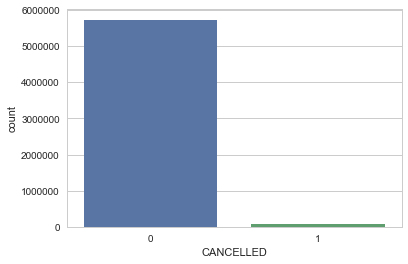

In [499]:
''' first lets do an exploratory analysis so we can guess which features are most important 
first is looks like a very small percentage of flights are cancelled. 
when we split the data set into test/train we need to keep that in mind '''
print(df3['CANCELLED'].value_counts())
sns.countplot(x='CANCELLED', data=df3)

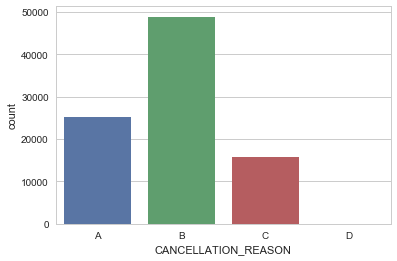

In [500]:
'''cancellation_reason: carrier, weather, national airsystem, security'''
sns.countplot(x="CANCELLATION_REASON",data=df3)

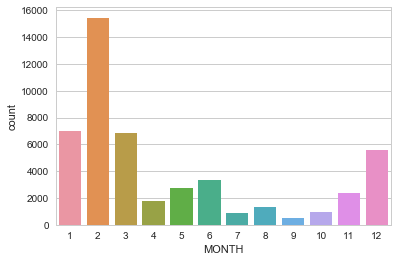

In [501]:
'''lets specifically look at cancellation_reason B, weather related, and group the data by month.  is there a month 
with more weather related cancellations?  Unsurprisingly, most weather related cancellations happen in winter months'''
sns.countplot(x = "MONTH",data=df3[df3["CANCELLATION_REASON"]=='B'])


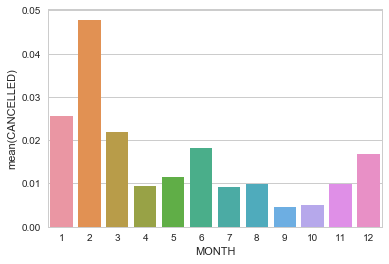

In [502]:
'''for this to make sense, we should be finding the percentage of flights that were cancelled as opposed to the total 
cancelled. We can do that by plotting the mean of 'CANCELLED' for each of the months '''
grouped_month = df3[['MONTH','CANCELLED']].groupby(['MONTH'],as_index=False).mean()
sns.barplot(x='MONTH', y='CANCELLED', data=grouped_month)


In [503]:
# next we will integrate the latitude/longitude information into the flights dataframe
df2 = df2.set_index("IATA_CODE")
df3['ORIGIN_LAT']=(df2['LATITUDE'][df3["ORIGIN_AIRPORT"][:]]).reset_index()[['LATITUDE']]
df3['ORIGIN_LONG']=(df2['LONGITUDE'][df3["ORIGIN_AIRPORT"][:]]).reset_index()[['LONGITUDE']]
df3['DEST_LAT']=(df2['LATITUDE'][df3["DESTINATION_AIRPORT"][:]]).reset_index()[['LATITUDE']]
df3['DEST_LONG']=(df2['LONGITUDE'][df3["DESTINATION_AIRPORT"][:]]).reset_index()[['LONGITUDE']]
df3.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_LAT,ORIGIN_LONG,DEST_LAT,DEST_LONG
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,NaN,NaN,NaN,NaN,NaN,NaN,33.94254,-118.40807,26.68316,-80.09559
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,NaN,NaN,NaN,NaN,NaN,NaN,37.61900,-122.37484,35.21401,-80.94313
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,NaN,NaN,NaN,NaN,NaN,NaN,33.94254,-118.40807,25.79325,-80.29056
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,NaN,NaN,NaN,NaN,NaN,NaN,47.44898,-122.30931,61.17432,-149.99619


In [504]:
def barplot_feature(df,feature, target = 'CANCELLED',cut = False, bins = 3):
    '''Plot of cancellation rate for various features. More continuous features can be binned together to convert
    to ranges of values
    
    df: the dataframe where the data is coming from
    feature: the feature to be plotted, must be a string a match a feature in df
    target: the prediction value, must be a string and match a feature in df
    cut: use cut if feature has continuous values.  '''
    if cut == True:
        # define a new feature which specifies a range of values for 'feature'.  ranges are determined according to 'bin'
        df['bins'] = pd.cut(df3[feature],bins)
        group_df = df[['bins',target]].groupby(['bins']).mean()
        return group_df.plot(kind='bar')
        #plt.title(feature)
    else:
        group_df = df[[feature,target]].groupby([feature],as_index=False).mean()
        return sns.barplot(x = feature, y = target, data=group_df)
        

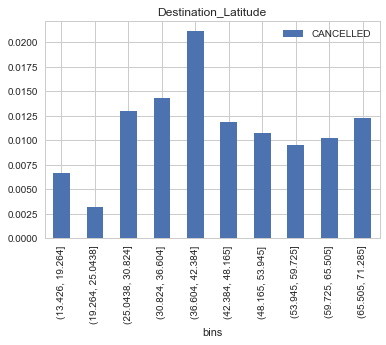

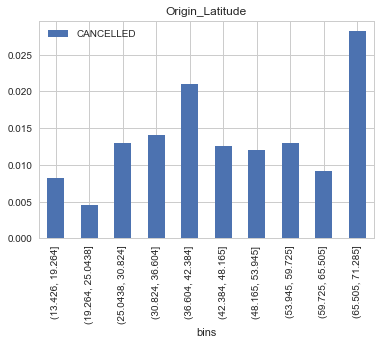

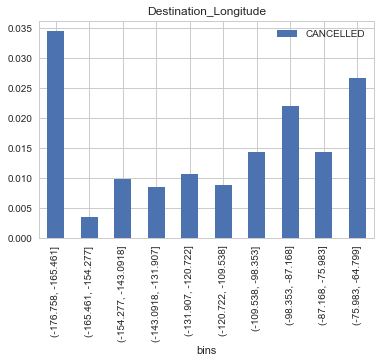

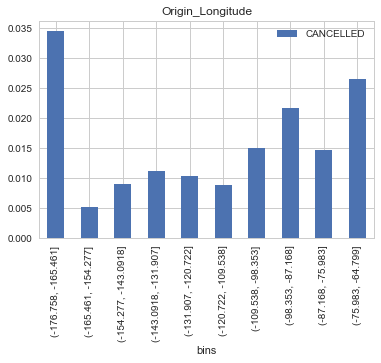

In [505]:
#how much does airport location play a role?
barplot_feature(df3,'DEST_LAT',cut = True, bins = 10)
plt.title('Destination_Latitude')
barplot_feature(df3,'ORIGIN_LAT',cut = True, bins = 10)
plt.title('Origin_Latitude')
barplot_feature(df3,'DEST_LONG',cut = True, bins = 10)
plt.title('Destination_Longitude')
barplot_feature(df3,'ORIGIN_LONG',cut = True, bins = 10)
plt.title('Origin_Longitude')

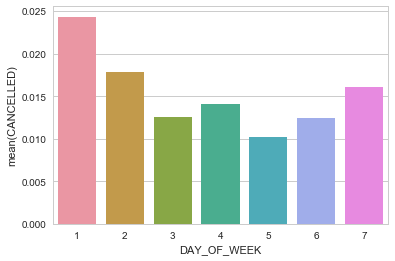

In [506]:
#day of week does not seem to matter much
barplot_feature(df3,'DAY_OF_WEEK')

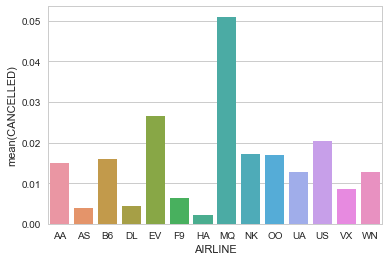

In [507]:
#airline analysis - one airline really sticks out
barplot_feature(df3,'AIRLINE')

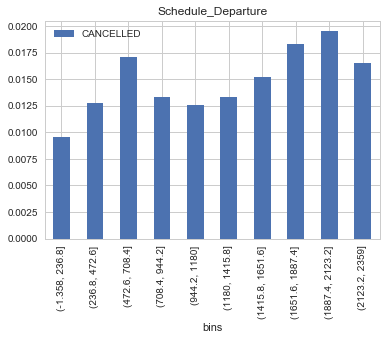

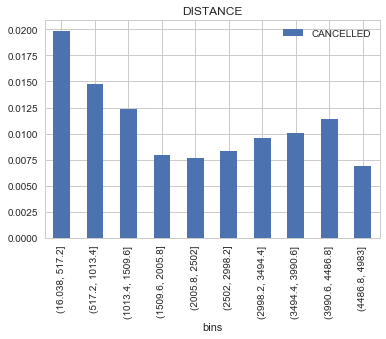

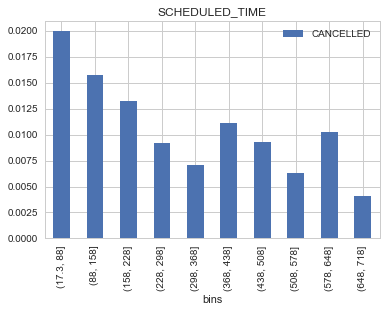

In [508]:
#SCHEDULED_DEPARTURE, later flights are slightly more likely to be cancelled?
barplot_feature(df3,'SCHEDULED_DEPARTURE', cut = True, bins = 10)
plt.title('Schedule_Departure')
barplot_feature(df3,'DISTANCE', cut = True, bins = 10)
plt.title('DISTANCE')
barplot_feature(df3,'SCHEDULED_TIME', cut = True, bins = 10)
plt.title('SCHEDULED_TIME')



## data preprocessing
Now that we have a visual overview of the data, lets prepare the data for the learning algorithms.  this includes choosing the features we will learn on, filling in missing values and converting categorical data to numerical or boolean data.

In [509]:
'''The data has a lot of missing values but a lot of it is in columns we don't want anyways. Let's list the features we 
want to keep. Then get rid of rows that have missing data. We will use the airport location as opposed to code
to decrease the number of features as we would need a dummy feature for each airport'''
features = ["MONTH","DAY_OF_WEEK","AIRLINE","SCHEDULED_DEPARTURE","SCHEDULED_ARRIVAL","DISTANCE",
           "SCHEDULED_TIME","DEST_LAT","ORIGIN_LAT","DEST_LONG","ORIGIN_LONG", "CANCELLED"]
df4 = df3[features]
#now drop any missing values
df4 = df4.dropna()
# set the predictions vector
y = df4[['CANCELLED']].as_matrix()
#sklearn requires the data to be shaped this way
c, r = y.shape
y = y.reshape(c,)
# drop the predictions vector from the features matrix
X = df4.drop(['CANCELLED'],axis=1)
print(X.count())
print('------------------------')
print(X.info())

MONTH                  5323693
DAY_OF_WEEK            5323693
AIRLINE                5323693
SCHEDULED_DEPARTURE    5323693
SCHEDULED_ARRIVAL      5323693
DISTANCE               5323693
SCHEDULED_TIME         5323693
DEST_LAT               5323693
ORIGIN_LAT             5323693
DEST_LONG              5323693
ORIGIN_LONG            5323693
dtype: int64
------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5323693 entries, 0 to 5819078
Data columns (total 11 columns):
MONTH                  int64
DAY_OF_WEEK            int64
AIRLINE                object
SCHEDULED_DEPARTURE    int64
SCHEDULED_ARRIVAL      int64
DISTANCE               int64
SCHEDULED_TIME         float64
DEST_LAT               float64
ORIGIN_LAT             float64
DEST_LONG              float64
ORIGIN_LONG            float64
dtypes: float64(5), int64(5), object(1)
memory usage: 487.4+ MB
None


In [510]:
'''We will need to create dummy variables for each of the categorical features in order to use this feature 
in the learning algorithms.  This can be easily done using the pandas library.  Even though month and day can be represented
as integers, its still categorical data and the numbers dont have analytical meaning'''
X = pd.concat([X, pd.get_dummies(X['AIRLINE'])], axis=1).drop(['AIRLINE'],axis=1)
X = pd.concat([X, pd.get_dummies(X['MONTH'],prefix="MONTH")], axis=1).drop(['MONTH'],axis=1)
X = pd.concat([X, pd.get_dummies(X['DAY_OF_WEEK'],prefix="DAY")], axis=1).drop(['DAY_OF_WEEK'],axis=1)
X.head()

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DISTANCE,SCHEDULED_TIME,DEST_LAT,ORIGIN_LAT,DEST_LONG,ORIGIN_LONG,AA,AS,...,MONTH_9,MONTH_11,MONTH_12,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6,DAY_7
0,5,430,1448,205.0,47.44898,61.17432,-122.30931,-149.99619,0,1,...,0,0,0,0,0,0,1,0,0,0
1,10,750,2330,280.0,26.68316,33.94254,-80.09559,-118.40807,1,0,...,0,0,0,0,0,0,1,0,0,0
2,20,806,2296,286.0,35.21401,37.61900,-80.94313,-122.37484,0,0,...,0,0,0,0,0,0,1,0,0,0
3,20,805,2342,285.0,25.79325,33.94254,-80.29056,-118.40807,1,0,...,0,0,0,0,0,0,1,0,0,0
4,25,320,1448,235.0,61.17432,47.44898,-149.99619,-122.30931,0,1,...,0,0,0,0,0,0,1,0,0,0


## Now we can start making predictions

In [511]:
''' Lets write some functions for computing the results so we can easily compare different models, feature selections, etc
'''
def compute_false_negatives(target, predictions):
    # rate at which model predicts a 0 but target hould be a 1
    df = pd.DataFrame({"target": target, "predictions": predictions})
    return df[(df["target"] == 1) & (df["predictions"] == 0)].shape[0] / (df[(df["target"] == 1)].shape[0] + 1)

def compute_false_positives(target, predictions):
    # rate at which model predicts a 1 but target is a 0
    df = pd.DataFrame({"target": target, "predictions": predictions})
    return df[(df["target"] == 0) & (df["predictions"] == 1)].shape[0] / (df[(df["target"] == 0)].shape[0] + 1)

def display_metrics(target,predictions):
   # print("accuracy : ", compute_error(model, target,predictions))
    print("false negative rate : ", compute_false_negatives(target,predictions))
    print("false positive rate : ", compute_false_positives(target,predictions))

In [512]:
# split data in training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# we want to standardize (0 mean, unit variance) the features that are on the same scale.  we won't do this for the 
# binary (dummy) features we created.  we first need to seperate those two groups of features
scale_features = ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DISTANCE',
        'DEST_LAT', 'ORIGIN_LAT', 'DEST_LONG', 'ORIGIN_LONG']
X_train_cat = X_train.drop(scale_features,axis=1).as_matrix()
X_test_cat = X_test.drop(scale_features,axis=1).as_matrix()
# mean and variance is calculated for features in the scale_features list for the training set
scaler = preprocessing.StandardScaler().fit(X_train[scale_features])
# apply the scaling transformation calculated above to these features in the trainging set
X_train_transformed = scaler.transform(X_train[scale_features])
# add these features back to the categorical/dummy features
X_train_final = np.concatenate((X_train_transformed,X_train_cat),axis=1)

'''Logistic Regression can be used for binary classification. Setting class_weight to "balanced" will account for the 
mismatch of False over True in the data set. Without this flag, it would be easy for the algorithm to just also predict
FALSE with low error but that obviously defeats the purpose!'''
clf = LogisticRegression(random_state=1, class_weight="balanced").fit(X_train_final, y_train)
# test features are scaled by values calculated with the train set
X_test_transformed = scaler.transform(X_test[scale_features])
X_test_final = np.concatenate((X_test_transformed,X_test_cat),axis=1)
predictions = clf.predict(X_test_final)


In [513]:
print("mean accuracy : ",clf.score(X_test_final, y_test) )
display_metrics(y_test,predictions)

mean accuracy :  0.687380565372
false negative rate :  0.30887823585810165
false positive rate :  0.3126811305922529


In [514]:
'''Which features are most important in our model? We can check this by looking at the fit coefficents'''
coeff_df=pd.DataFrame(X.columns)
coeff_df.columns = ['Features']
coeff_df['Coefficient Estimate'] = pd.Series(clf.coef_[0])
coeff_df = coeff_df.sort_values(by="Coefficient Estimate")
print(coeff_df.head())
print(coeff_df.tail())

    Features  Coefficient Estimate
2   DISTANCE             -1.564076
11        DL             -1.399830
30   MONTH_9             -1.375274
9         AS             -1.163774
37     DAY_5             -0.787594
   Features  Coefficient Estimate
22  MONTH_1              0.380063
16       NK              0.398086
12       EV              0.400581
15       MQ              1.014092
23  MONTH_2              1.077268


## Predict weather related cancellations
Instead of predicting whether a flight in cancelled or not, lets try to predict if a flight is cancelled for whether related reasons.  The original data splits the cancellations into 4 categories: "carrier", "weather", "national airsystem", "security". It seems reasonable to make the statement that only the "weather" categorie would be predictible. Let's see if this improves our results.

In [544]:
# fill NaN cells (eg no cancellation) with a 0 then create dummy features.  Isolate REASON_B (weather) to use at
# in place of y (prediction vector)
y_reason = df3[['CANCELLATION_REASON']].fillna(value=0)
y_reason = pd.get_dummies(y_reason['CANCELLATION_REASON'],prefix="REASON")[['REASON_B']]

# now add this new column to the original dataframe and drop missing values.  doing it in this order ensures 
# the rows match up for the features and predictions vectors
features = ["MONTH","DAY_OF_WEEK","AIRLINE","SCHEDULED_DEPARTURE","SCHEDULED_ARRIVAL","DISTANCE",
           "SCHEDULED_TIME","DEST_LAT","ORIGIN_LAT","DEST_LONG","ORIGIN_LONG"]
df4 = pd.concat([df3[features],y_reason],axis=1)
df4 = df4.dropna()
# set the predictions vector
y = df4[['REASON_B']].as_matrix()
c, r = y.shape
y = y.reshape(c,)
# drop the predictions vector from the features matrix
X = df4.drop(['REASON_B'],axis=1)
# create dummy features
X = pd.concat([X, pd.get_dummies(X['AIRLINE'])], axis=1).drop(['AIRLINE'],axis=1)
X = pd.concat([X, pd.get_dummies(X['MONTH'],prefix="MONTH")], axis=1).drop(['MONTH'],axis=1)
X = pd.concat([X, pd.get_dummies(X['DAY_OF_WEEK'],prefix="DAY")], axis=1).drop(['DAY_OF_WEEK'],axis=1)


In [541]:
'''now y tells us whether a flight was cancelled due to weather reasons or not.  everything else is the same.'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
scale_features = ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DISTANCE',
        'DEST_LAT', 'ORIGIN_LAT', 'DEST_LONG', 'ORIGIN_LONG']
X_train_cat = X_train.drop(scale_features,axis=1).as_matrix()
X_test_cat = X_test.drop(scale_features,axis=1).as_matrix()
scaler = preprocessing.StandardScaler().fit(X_train[scale_features])
X_train_transformed = scaler.transform(X_train[scale_features])
X_train_final = np.concatenate((X_train_transformed,X_train_cat),axis=1)
clf = LogisticRegression(random_state=1, class_weight="balanced").fit(X_train_final, y_train)
X_test_transformed = scaler.transform(X_test[scale_features])
X_test_final = np.concatenate((X_test_transformed,X_test_cat),axis=1)
predictions = clf.predict(X_test_final)


In [543]:
print("mean accuracy : ",clf.score(X_test_final, y_test) )
display_metrics(y_test,predictions)
'''Which features are most important in our model? We can check this by looking at the fit coefficents'''
coeff_df=pd.DataFrame(X.columns)
coeff_df.columns = ['Features']
coeff_df['Coefficient Estimate'] = pd.Series(clf.coef_[0])
coeff_df = coeff_df.sort_values(by="Coefficient Estimate")
print(coeff_df.head())
print(coeff_df.tail())

mean accuracy :  0.72834523401
false negative rate :  0.23349023951266787
false positive rate :  0.27200277506786025
   Features  Coefficient Estimate
14       HA             -3.228597
20       VX             -3.076096
30  MONTH_9             -2.079264
28  MONTH_7             -1.456227
29  MONTH_8             -1.143230
   Features  Coefficient Estimate
8        AA              0.844880
16       NK              0.900755
17       OO              0.968302
23  MONTH_2              1.721702
15       MQ              1.739513


## Where to go from here?
- Try different algorithm. Instead of using LogisticRegression, try perhaps a decision tree
- Feature engineering. Combine features into better features? Find more data with features that can expand upon what we already have, eg, perhaps weather for a given location on a given day?

In [549]:
processed_df = pd.read_csv(os.path.join(settings.PROCESSED_DIR,"train.csv"))
processed_df.columns

Index(['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DISTANCE',
       'SCHEDULED_TIME', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_LATITUDE', 'DESTINATION_LONGITUDE', 'REASON_B',
       'AIRLINE_AA', 'AIRLINE_AS', 'AIRLINE_B6', 'AIRLINE_DL', 'AIRLINE_EV',
       'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_MQ', 'AIRLINE_NK', 'AIRLINE_OO',
       'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_VX', 'AIRLINE_WN', 'MONTH_1',
       'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'MONTH_8', 'MONTH_9', 'MONTH_11', 'MONTH_12', 'DAY_OF_WEEK_1',
       'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5',
       'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'],
      dtype='object')

In [556]:
processed_df.columns

Index(['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DISTANCE',
       'SCHEDULED_TIME', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_LATITUDE', 'DESTINATION_LONGITUDE', 'REASON_B',
       'AIRLINE_AA', 'AIRLINE_AS', 'AIRLINE_B6', 'AIRLINE_DL', 'AIRLINE_EV',
       'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_MQ', 'AIRLINE_NK', 'AIRLINE_OO',
       'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_VX', 'AIRLINE_WN', 'MONTH_1',
       'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'MONTH_8', 'MONTH_9', 'MONTH_11', 'MONTH_12', 'DAY_OF_WEEK_1',
       'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5',
       'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'],
      dtype='object')

In [553]:
scale_features = settings.FEATURES not in settings.dummy_features

AttributeError: module 'settings' has no attribute 'FEATURES'

In [554]:
import settings


In [563]:
settings.reason

AttributeError: module 'settings' has no attribute 'reason'

In [564]:
settings.PROCESSED_DIR

'processed'

In [565]:
os.path

<module 'posixpath' from '/Users/test/anaconda/lib/python3.5/posixpath.py'>

In [567]:
settings.PREDICTOR

AttributeError: module 'settings' has no attribute 'PREDICTOR'

In [573]:
c1 = ["a","b","c","d","e","f","g"]
c2 = ["a","b","c"]


In [572]:
list1-list2

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [576]:
c3 = [list(filter(lambda x: x in c1, sublist)) for sublist not in c2]


SyntaxError: invalid syntax (<ipython-input-576-c5ddb46b6952>, line 1)

In [579]:
b1 = [1,2,3,4,5]
b2 = [3,4,5,6]
s2 = set(b2)
b3 = [val for val in b1 if val not in s2]

In [580]:
b3

[1, 2]

df3.head()

In [581]:
df3.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_LAT,ORIGIN_LONG,DEST_LAT,DEST_LONG,bins
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,NaN,NaN,NaN,NaN,61.17432,-149.99619,47.44898,-122.30931,"(158, 228]"
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,NaN,NaN,NaN,NaN,NaN,33.94254,-118.40807,26.68316,-80.09559,"(228, 298]"
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,NaN,NaN,NaN,NaN,NaN,37.61900,-122.37484,35.21401,-80.94313,"(228, 298]"
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,NaN,NaN,NaN,NaN,NaN,33.94254,-118.40807,25.79325,-80.29056,"(228, 298]"
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,NaN,NaN,NaN,NaN,NaN,47.44898,-122.30931,61.17432,-149.99619,"(228, 298]"


In [591]:
test = df3
list(pd.get_dummies(test['DAY_OF_WEEK'],prefix="DAY_OF_WEEK").columns)

['DAY_OF_WEEK_1',
 'DAY_OF_WEEK_2',
 'DAY_OF_WEEK_3',
 'DAY_OF_WEEK_4',
 'DAY_OF_WEEK_5',
 'DAY_OF_WEEK_6',
 'DAY_OF_WEEK_7']

In [585]:
new_dummy_features = ["A","B"]

In [598]:
new_dummy_features.append(iterable(
    pd.get_dummies(test['DAY_OF_WEEK'],prefix="DAY_OF_WEEK").columns))

NameError: name 'iterable' is not defined

In [597]:
new_dummy_features

['A',
 'B',
 Index(['DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
        'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'],
       dtype='object'),
 ['DAY_OF_WEEK_1',
  'DAY_OF_WEEK_2',
  'DAY_OF_WEEK_3',
  'DAY_OF_WEEK_4',
  'DAY_OF_WEEK_5',
  'DAY_OF_WEEK_6',
  'DAY_OF_WEEK_7'],
 ['DAY_OF_WEEK_1',
  'DAY_OF_WEEK_2',
  'DAY_OF_WEEK_3',
  'DAY_OF_WEEK_4',
  'DAY_OF_WEEK_5',
  'DAY_OF_WEEK_6',
  'DAY_OF_WEEK_7']]

In [603]:
new = ["A","B"]
new_dummy = pd.get_dummies(test['DAY_OF_WEEK'],prefix="DAY_OF_WEEK")
new_columns = list(new_dummy.columns)
new.append(new_columns)

In [605]:
new.append(["and","also","this"])

In [606]:
new = [item for sublist in new for item in sublist]

In [607]:
new

['A',
 'B',
 'DAY_OF_WEEK_1',
 'DAY_OF_WEEK_2',
 'DAY_OF_WEEK_3',
 'DAY_OF_WEEK_4',
 'DAY_OF_WEEK_5',
 'DAY_OF_WEEK_6',
 'DAY_OF_WEEK_7',
 'and',
 'also',
 'this']

In [618]:
alist=["a","b","c"]
with open(os.path.join(settings.PROCESSED_DIR, "example.csv"), "w") as fh:
    for item in alist:
        fh.write("%s," % item)

In [626]:
with open(os.path.join(settings.PROCESSED_DIR, "new_settings.txt"), "r") as f:
    lines = f.read().splitlines() 

In [627]:
lines

['AIRLINE_AA',
 'AIRLINE_AS',
 'AIRLINE_B6',
 'AIRLINE_DL',
 'AIRLINE_EV',
 'AIRLINE_F9',
 'AIRLINE_HA',
 'AIRLINE_MQ',
 'AIRLINE_NK',
 'AIRLINE_OO',
 'AIRLINE_UA',
 'AIRLINE_US',
 'AIRLINE_VX',
 'AIRLINE_WN',
 'MONTH_1',
 'MONTH_2',
 'MONTH_3',
 'MONTH_4',
 'MONTH_5',
 'MONTH_6',
 'MONTH_7',
 'MONTH_8',
 'MONTH_9',
 'MONTH_11',
 'MONTH_12',
 'DAY_OF_WEEK_1',
 'DAY_OF_WEEK_2',
 'DAY_OF_WEEK_3',
 'DAY_OF_WEEK_4',
 'DAY_OF_WEEK_5',
 'DAY_OF_WEEK_6',
 'DAY_OF_WEEK_7']

In [ ]:
with open('C:/path/numbers.txt') as f:
    lines = f.read().splitlines()